In [113]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt

In [114]:
# files to read => chb01_03.edf, chb01_04.edf, chb01_15.edf,  chb01_16.edf,  chb01_18.edf,  chb01_21.edf,  chb01_26.edf,  chb02_16.edf, chb02_19.edf, chb03_01.edf, chb03_02.edf, chb03_03.edf, chb03_04.edf
files_to_read = ['chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb01_18.edf', 'chb01_21.edf', 'chb01_26.edf', 'chb02_16.edf', 'chb02_19.edf', 'chb03_01.edf', 'chb03_02.edf', 'chb03_03.edf', 'chb03_04.edf' ]
seizure_seconds_each_file_start_and_end_seconds = [('chb01_03.edf',2996, 3036), ('chb01_04.edf', 1467, 1494), ('chb01_15.edf', 1732, 1772), ('chb01_16.edf',1015, 1066),
 ('chb01_18.edf', 1720, 1810), ('chb01_21.edf', 327, 420), ('chb01_26.edf', 1862, 1963), ('chb02_16.edf', 130, 212), ('chb02_19.edf', 2972, 3053),
  ('chb03_01.edf', 362, 414), ('chb03_02.edf', 731, 796), ('chb03_03.edf', 432, 501), ('chb03_04.edf', 2162, 2214)]
signals = []

for file in files_to_read:
        f = pyedflib.EdfReader(file)
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')
        sigbufs = np.zeros((2, f.getNSamples()[0]))
        sigbufs[0] = f.readSignal(fz_cz_index)
        sigbufs[1] = f.readSignal(cz_pz_index)
        signals.append(np.array(sigbufs))
        f.close()
len(signals)

13

In [100]:
signals[0].shape

(2, 921600)

In [115]:
seizure_seconds_each_file_start_and_end_seconds[0][2]

3036

In [133]:
#split each signal into 20 * 256 second windows
window_size = 20 * 256
windowed_signals = []
y_labels = []
index = 0
for signal in signals:
    start_time = seizure_seconds_each_file_start_and_end_seconds[index][1]*256
    end_time = seizure_seconds_each_file_start_and_end_seconds[index][2]*256
    for i in range(0, signal.shape[1], window_size):
        windowed_signals.append(signal[:, i:i+window_size].T)
        #if i and i+window_size contains seizure time, then label it as 1, otherwise 0
        if i in range(start_time, end_time) or i+window_size in range(start_time, end_time):
            y_labels.append(1)
        else:
            y_labels.append(0)
    index += 1

In [134]:
print(len(windowed_signals), len(y_labels))

2145 2145


In [135]:
sum(y_labels)

54

In [136]:
windowed_signals[0].shape

(5120, 2)

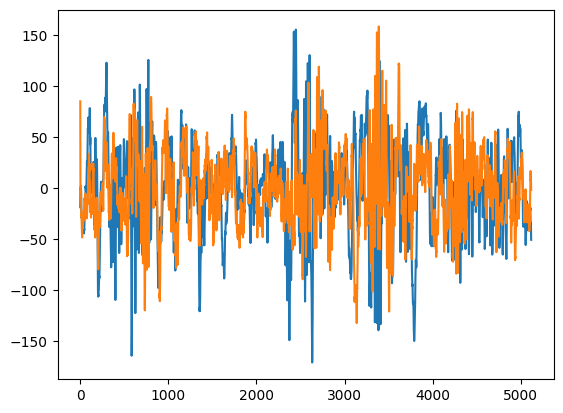

In [137]:
plt.plot(windowed_signals[0])

In [138]:
# sort the signals and labels by the 1 and 0 labels
windowed_signals = np.array(windowed_signals)
y_labels = np.array(y_labels)
sorted_index = np.argsort(y_labels)
windowed_signals = windowed_signals[sorted_index]
y_labels = y_labels[sorted_index]

C:\Users\alast\AppData\Local\Temp\ipykernel_12568\1766711838.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  windowed_signals = np.array(windowed_signals)
